In [1]:
import pandas as pd
import numpy as np

In [2]:
from tensorflow import keras
import tensorflow as tf

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from sklearn.model_selection import KFold

In [5]:
from IPython.display import clear_output

In [6]:
from matplotlib import pyplot as plt
import os, sys
sys.path.append(os.path.abspath("../../plots/"))
from plotter import plot_marginals

In [7]:
from itertools import product

In [8]:
from math import prod

In [9]:
from GPyOpt.methods import BayesianOptimization

In [10]:
from io import StringIO

In [11]:
from datetime import datetime

# Data preparation

Data can be found [here](http://mlr.cs.umass.edu/ml/machine-learning-databases/census-income/).

In [12]:
data = pd.read_csv(
#     "/cluster/scratch/bramva/deep-learning-course/data/census-income/census-income.data",
    "data/census-income.data",
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ],
)

In [13]:
categoricals = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

In [14]:
data.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [15]:
data.iloc[0, :]

age                           39
workclass              State-gov
fnlwgt                     77516
education              Bachelors
education-num                 13
marital-status     Never-married
occupation          Adm-clerical
relationship       Not-in-family
race                       White
sex                         Male
capital-gain                2174
capital-loss                   0
hours-per-week                40
native-country     United-States
income                     <=50K
Name: 0, dtype: object

In [16]:
for categorical in categoricals:
    data[categorical] = LabelEncoder().fit_transform(data[categorical])
    values = data[categorical].unique()
    np.random.shuffle(values)
    data[categorical] = values[data[categorical]]

In [17]:
means = data.mean()

In [18]:
data -= means

In [19]:
stds = data.std()

In [20]:
data /= stds

In [21]:
dataset = data.values

In [22]:
ordering = np.arange(dataset.shape[0])
np.random.shuffle(ordering)
dataset = dataset[ordering]

In [23]:
cutoff = round(dataset.shape[0] * .1)

In [24]:
train, labels = dataset[:, 1:], dataset[:, 0]

# Utilities

In [25]:
class PlotLosses(keras.callbacks.Callback):
    def __init__(
        self,
        metrics=None,
        validation=True,
    ):
        self.metrics = ["loss"]
        if metrics:
            self.metrics += metrics
        if validation:
            for i in reversed(range(len(self.metrics))):
                self.metrics.insert(i + 1, "val_" + self.metrics[i])
        self.hist_metrics = [list() for metric in self.metrics]
        
    def on_train_begin(self, logs={}):
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            hist_metric.append(logs.get(metric))

        clear_output(wait=True)
        
        self.fig = plt.figure(figsize=(15, 7))
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            plt.plot(range(len(self.hist_metrics[0])), hist_metric, label=metric)
        plt.legend()
        plt.show()

    def __len__(self):
        return len(self.hist_metrics[0])

In [26]:
def log_space(x, shift=1e-12): return np.log(x + shift)
def un_log_space(x, shift=1e-12): return np.exp(x) - shift

# Regularization versus model size

In [27]:
def build_model(
    before_trainable_layers=[],
    random_layers=[],
    after_trainable_layers=[],
    regularization=1e-6,
):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(train.shape[1])))
    
    for i, layer_size in enumerate(before_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        ))
        
    for random_layer_size in random_layers:
        model.add(keras.layers.Dense(
            random_layer_size,
            activation="tanh",
            trainable=False,
        ))
    
    previous_size = random_layers[-1] if random_layers else before_trainable_layers[-1] if before_trainable_layers else train.shape[1]
    for i, layer_size in enumerate(after_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        ))
        
    model.add(keras.layers.Dense(1))
    return model

In [28]:
domain = [
    {
        "name": "l1_factor",
        "type": "continuous",
        "domain": (log_space(0), log_space(1e1)),
    }
]

In [30]:
def test(hyperparameters):
    l1_factor = hyperparameters[0, 0]
    
    model = build_model([100], [100, 100], [100], un_log_space(l1_factor))
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    train_ids, test_ids = next(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0])))
    half_validate = round(len(test_ids) / 2)
    
    model.fit(
        train[train_ids], labels[train_ids],
        64,
        epochs=20,
        shuffle=True,
        validation_data=(
            train[test_ids][:half_validate], labels[test_ids][:half_validate],
        ),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=3,
                restore_best_weights=True,
            ),
            PlotLosses(),
        ],
    )
    
    score = model.evaluate(
        train[test_ids][half_validate:], labels[test_ids][half_validate:],
        verbose=0,
    )
    
    return score

In [48]:
middle_sizes = [10, 100, 1_000]
grid_res = 30
scan_l2 = np.zeros((len(middle_sizes), grid_res, 2))

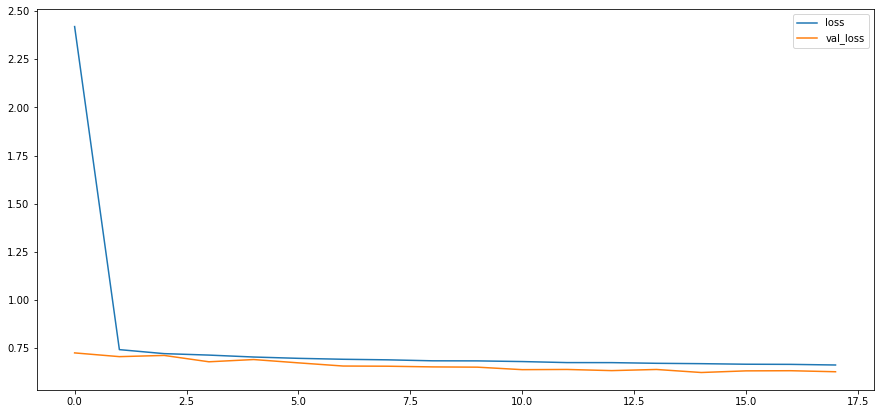

29304/29304 [==============================] - 1s 38us/sample - loss: 0.6638 - val_loss: 0.6288


In [49]:
for i, middle_size in enumerate(middle_sizes):
    for j, l1 in enumerate(np.linspace(log_space(0), log_space(1e-1), grid_res)):
        scan_l2[i, j, 0] = l1
        scan_l2[i, j, 1] = test(np.array([[l1]]))

In [50]:
ms = np.array(middle_sizes).reshape(-1, 1)

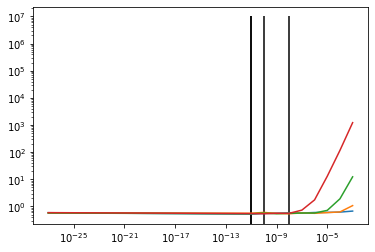

In [228]:
plt.loglog(
    (un_log_space(scan[:, :, 0])).transpose(),
    (scan[:, :, 1]).transpose(),
)
plt.vlines(un_log_space(scan[np.arange(scan.shape[0]), np.argmin(scan[:, :, 1], axis=1), 0]), ymin=0, ymax=1e7)

In [234]:
scan[np.arange(scan.shape[0]), np.argmin(scan[:, :, 1], axis=1), 0] / ms.reshape(-1)

array([-2.53284360e+00, -1.84206807e-01, -2.53284360e-02, -2.30258509e-03])

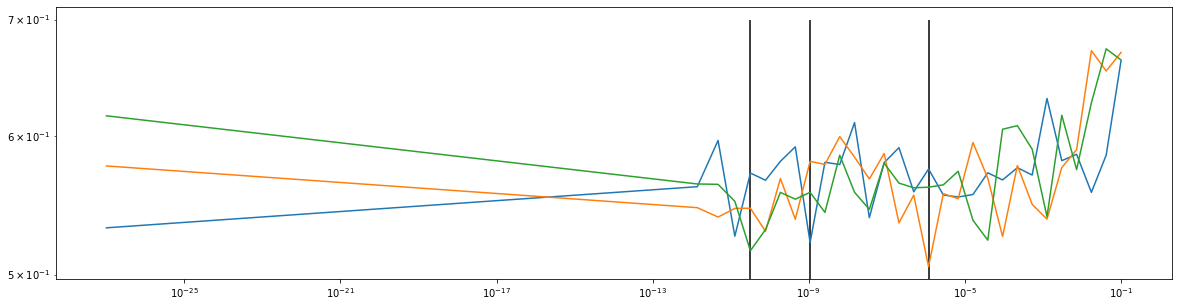

In [56]:
plt.figure(figsize=(20, 5))
plt.loglog(
    (un_log_space(scan_l2[:, :, 0])).transpose(),
    (scan_l2[:, :, 1]).transpose(),
)
plt.vlines(un_log_space(scan_l2[np.arange(scan_l2.shape[0]), np.argmin(scan_l2[:, :, 1], axis=1), 0]), ymin=0, ymax=.7)

In [57]:
un_log_space(scan_l2[np.arange(scan_l2.shape[0]), np.argmin(scan_l2[:, :, 1], axis=1), 0])

array([1.08163673e-09, 1.17210130e-06, 3.19034456e-11])

In [78]:
list(map(lambda t: (t[0], un_log_space(t[1])), results))

[(10, array([3.52170344e-12])),
 (100, array([0.00016391])),
 (1000, array([3.16736597e-05])),
 (10000, array([5.154616e-11]))]

# Grid scans

In [32]:
folds = 10

In [33]:
sizes = [10, 100]
max_random_depth = 2

before_options = [[], [100]]
random_options = [[size] * i for size in sizes for i in range(max_random_depth + 1)]
after_options = [[], [10]]

In [34]:
model_configurations = np.array(list(product(before_options, random_options, after_options)))
model_configurations = model_configurations.reshape(
    len(before_options),
    len(sizes),
    max_random_depth + 1,
    len(after_options),
    len((before_options, random_options, after_options)),
)
model_configurations.shape, prod(model_configurations.shape[:-1]), folds

((2, 2, 3, 2, 3), 24, 10)

In [35]:
model_configurations

array([[[[[list([]), list([]), list([])],
          [list([]), list([]), list([10])]],

         [[list([]), list([10]), list([])],
          [list([]), list([10]), list([10])]],

         [[list([]), list([10, 10]), list([])],
          [list([]), list([10, 10]), list([10])]]],


        [[[list([]), list([]), list([])],
          [list([]), list([]), list([10])]],

         [[list([]), list([100]), list([])],
          [list([]), list([100]), list([10])]],

         [[list([]), list([100, 100]), list([])],
          [list([]), list([100, 100]), list([10])]]]],



       [[[[list([100]), list([]), list([])],
          [list([100]), list([]), list([10])]],

         [[list([100]), list([10]), list([])],
          [list([100]), list([10]), list([10])]],

         [[list([100]), list([10, 10]), list([])],
          [list([100]), list([10, 10]), list([10])]]],


        [[[list([100]), list([]), list([])],
          [list([100]), list([]), list([10])]],

         [[list([100]), list([100]

In [68]:
results = np.zeros(model_configurations.shape[:-1] + (folds,))

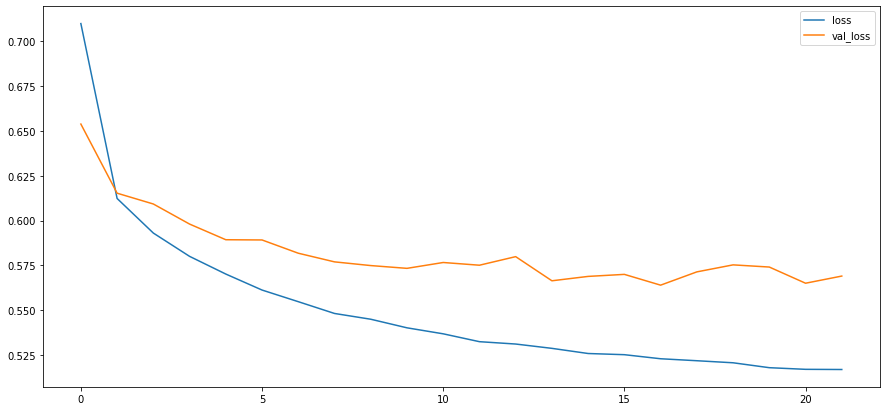

29305/29305 [==============================] - 1s 37us/sample - loss: 0.5169 - val_loss: 0.5690


In [71]:
for i, model_type in enumerate(model_configurations.reshape(-1, 3)):
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        half_validate = round(len(test_ids) / 2)
        
        model = build_model(*model_type)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                PlotLosses(),
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results.reshape(-1, folds)[i, j] = score

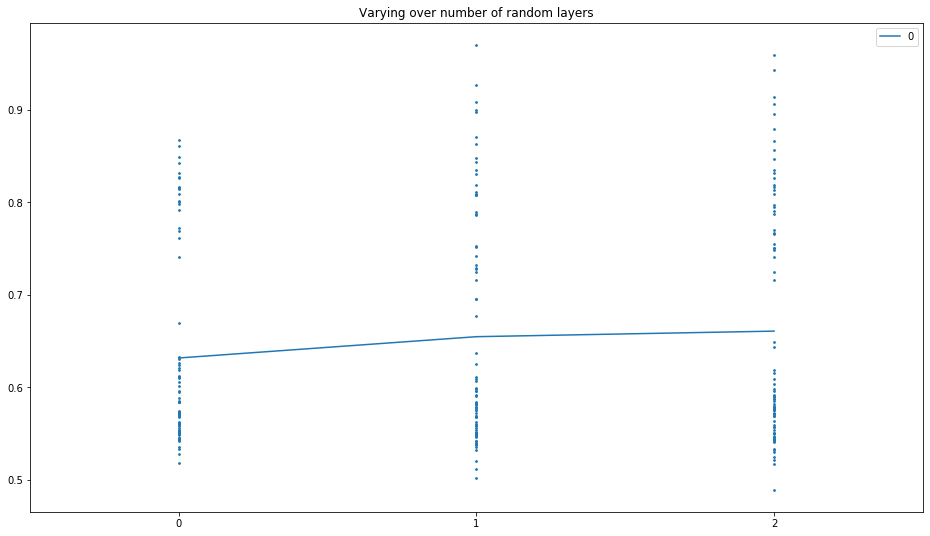

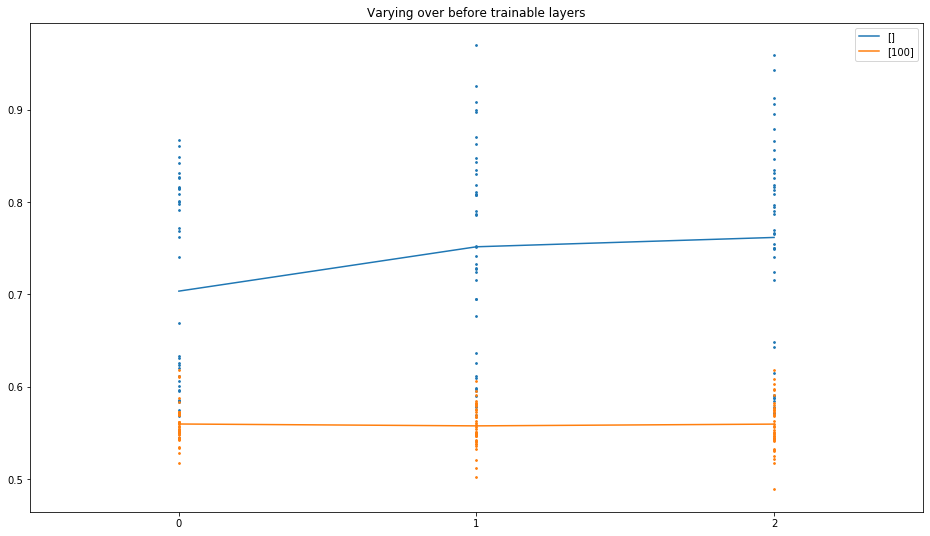

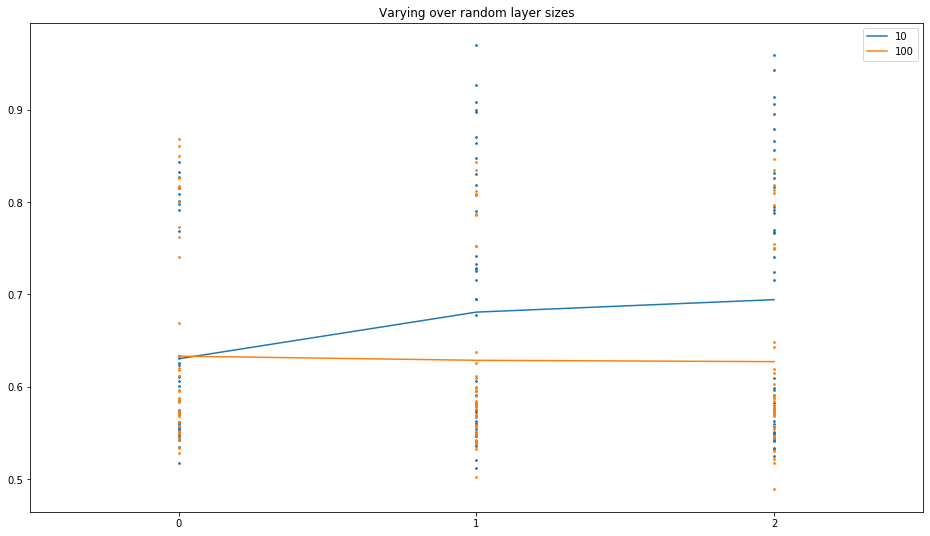

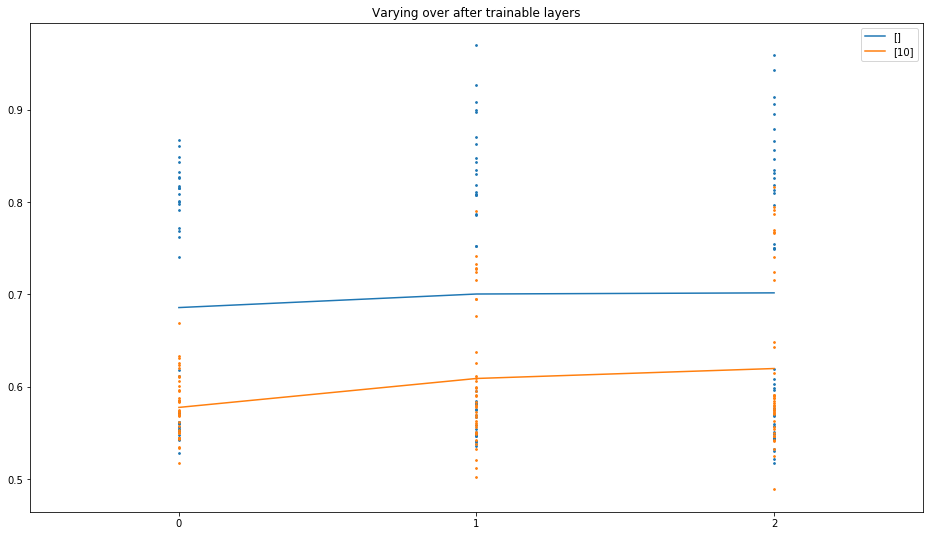

In [37]:
plot_marginals(
    results,
    [
        "Before trainable layers",
        "Random layer sizes",
        "Number of random layers",
        "After trainable layers",
    ],
    [
        before_options,
        sizes,
        list(range(3)),
        after_options,
    ],
    2,
)

In [72]:
for model_type, result_list in zip(model_configurations.reshape(-1, 3), results.reshape(-1, folds)):
    print(*model_type)
    print("\n", "score:", np.mean(result_list), "\t", np.std(result_list), "\n\n")

[] [] []

 score: 0.8099410301659324 	 0.020408590917771537 


[] [] [10]

 score: 0.5930019931833502 	 0.02905636500807743 


[] [10] []

 score: 0.8832208156235213 	 0.0438907938436414 


[] [10] [10]

 score: 0.7228511023146049 	 0.029488262546903284 


[] [10, 10] []

 score: 0.8875837666640531 	 0.042122057197221625 


[] [10, 10] [10]

 score: 0.7671968796530242 	 0.03063710406322782 


[] [] []

 score: 0.8108844328067475 	 0.04049126715179144 


[] [] [10]

 score: 0.6005331129374636 	 0.033070992294900854 


[] [100] []

 score: 0.7990432056660464 	 0.028825968726679096 


[] [100] [10]

 score: 0.601352504587921 	 0.019412449602074285 


[] [100, 100] []

 score: 0.7923302110674351 	 0.036066740365039124 


[] [100, 100] [10]

 score: 0.5997796718780836 	 0.025396633836939672 


[100] [] []

 score: 0.5620647714719396 	 0.018116027170175557 


[100] [] [10]

 score: 0.5559563268745333 	 0.023824483528513317 


[100] [10] []

 score: 0.5595715071900955 	 0.01844073021865352 



In [82]:
with open("output/result.output", 'w+') as file:
    file.writelines([str(results.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results.reshape(-1, folds))

#### Example of how to read results from files

file = open("output/result.output", "r")
shape = tuple(map(int, file.readline().rstrip().split(",")))
data = np.genfromtxt(StringIO(file.read()))
results = data.reshape(shape)

results.shape

## Residual

### Random layers only

In [28]:
def build_residual_model(
    before_trainable_layers=[],
    random_layers=0,
    after_trainable_layers=[],
    regularization=1e-6,
):
    inputs = [keras.layers.Input(shape=(train.shape[1],))]
    state = inputs[0]
    
    for i, layer_size in enumerate(before_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        state = keras.layers.BatchNormalization()(state)
        
    for _ in range(random_layers):
        state = keras.layers.Add()([keras.layers.Dense(
            before_trainable_layers[-1],
            activation="tanh",
            trainable=False,
        )(state), state])
        state = keras.layers.BatchNormalization()(state)
    
    for i, layer_size in enumerate(after_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        
    state = keras.layers.Dense(1)(state)
    return keras.Model(inputs, outputs=state)

In [34]:
folds = 10

In [35]:
max_random_depth = 40
random_steps = 10

before_options = [[50], [200]]
random_options = list(range(0, max_random_depth + 1, random_steps))
after_options = [[], [10]]

values = [before_options, random_options, after_options]

In [36]:
model_configurations_residual = np.array(list(product(*values)))
model_configurations_residual = model_configurations_residual.reshape(
    len(before_options), 
    len(random_options),
    len(after_options),
    len((before_options, random_options, after_options)),
)
model_configurations_residual.shape, prod(model_configurations_residual.shape[:-1]), folds

((2, 5, 2, 3), 20, 10)

In [32]:
results_residual = np.zeros(model_configurations_residual.shape[:-1] + (folds,))

In [ ]:
for i, model_type in reversed(list(enumerate(model_configurations_residual.reshape(-1, 3)))):
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        print(i)
        half_validate = round(len(test_ids) / 2)
        
        model = build_residual_model(*model_type)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                ),
                PlotLosses(),
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results_residual.reshape(-1, folds)[i, j] = score

In [114]:
with open("output/result2.output", 'w+') as file:
    file.writelines([str(results_residual.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results_residual.reshape(-1, folds))

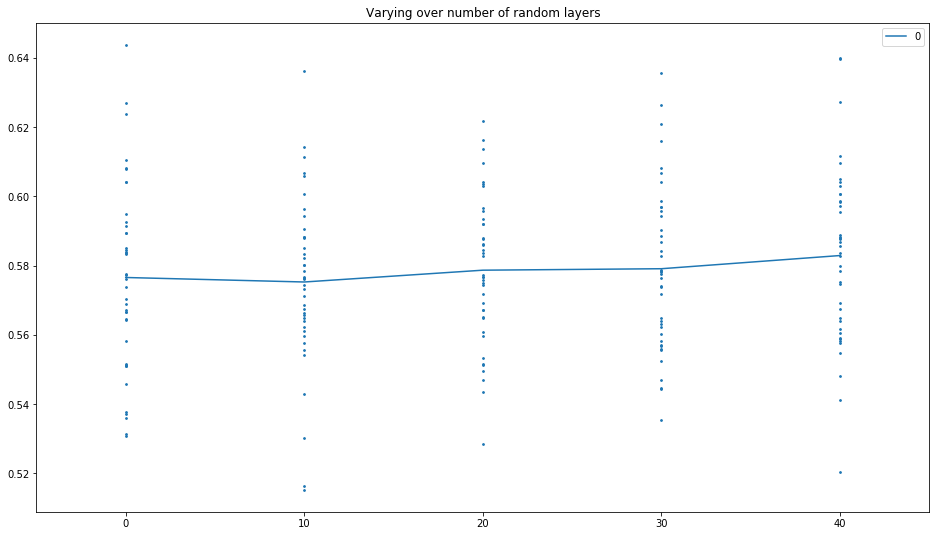

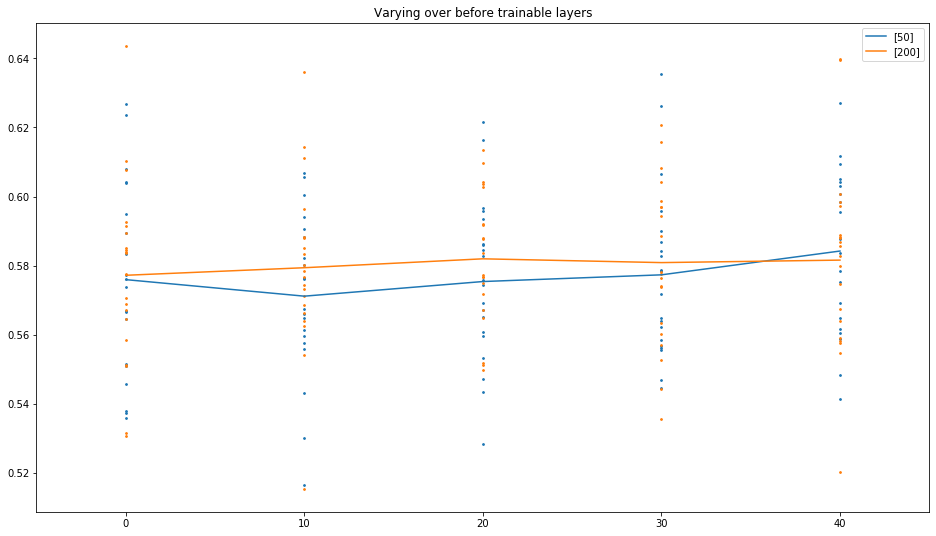

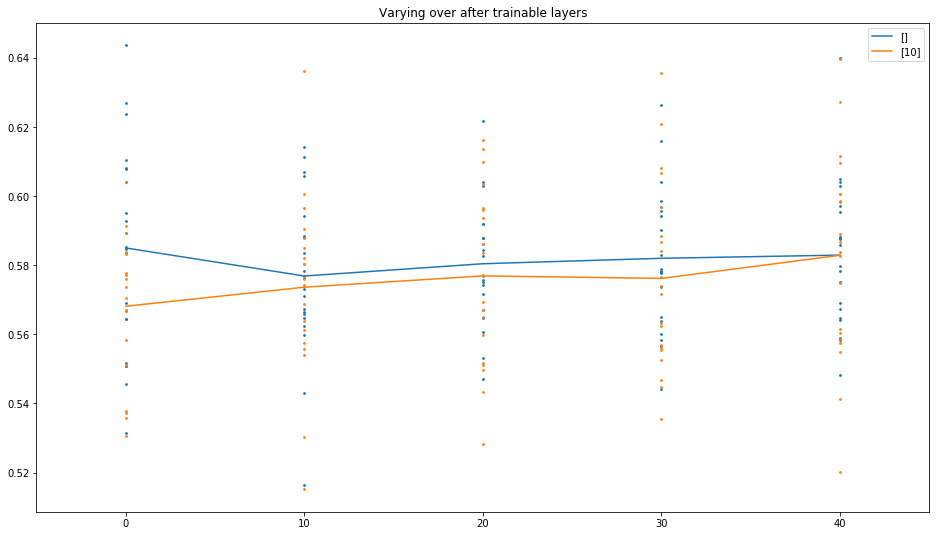

In [100]:
plot_marginals(
    results_residual,
    [
        "Before trainable layers",
        "Number of random layers",
        "After trainable layers",
    ],
    values,
    1,
)

### Scalar per random residual layer

In [31]:
class Scalar(keras.layers.Layer):
    def __init__(self):
        super(Scalar, self).__init__()
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(),
            initializer=tf.random_uniform_initializer(),
            trainable=True,
        )
        
    def call(self, x):
        return tf.multiply(x, self.kernel)

In [31]:
def build_double_residual_model(
    before_trainable_layers=[],
    random_layers=0,
    after_trainable_layers=[],
    regularization=1e-6,
    random_activation="tanh",
):
    inputs = [keras.layers.Input(shape=(train.shape[1],))]
    state = inputs[0]
    
    for i, layer_size in enumerate(before_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        state = keras.layers.BatchNormalization()(state)
        
    for i in range(random_layers):
        random_layer_output = keras.layers.Dense(
            before_trainable_layers[-1],
            activation=random_activation,
            trainable=False,
        )(state)
        random_layer_output_scaled = Scalar(trainable=True)(random_layer_output)
        state = keras.layers.Add()([state, random_layer_output_scaled])
        state = keras.layers.BatchNormalization()(state)
    
    for i, layer_size in enumerate(after_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        
    state = keras.layers.Dense(1)(state)
    return keras.Model(inputs, outputs=state)

In [31]:
results_double_residual = np.zeros(model_configurations_residual.shape[:-1] + (folds,))

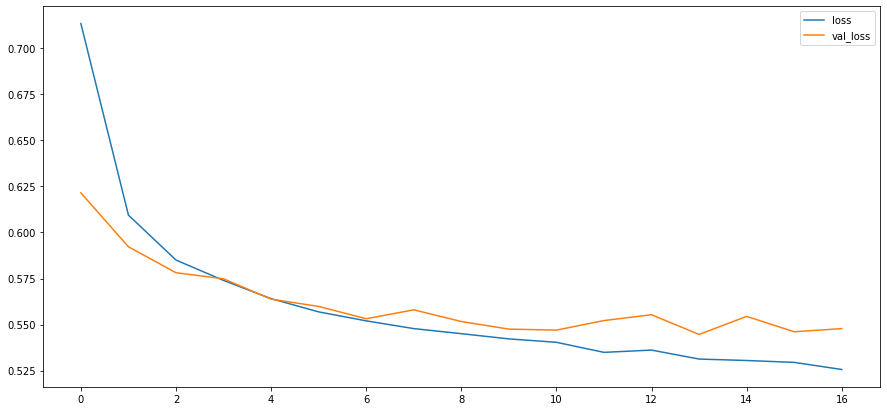

29305/29305 [==============================] - 10s 356us/sample - loss: 0.5256 - val_loss: 0.5478


In [40]:
for i, model_type in list(enumerate(model_configurations_residual.reshape(-1, 3)))[16:]:
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        print(i, j, sep=", ")
        half_validate = round(len(test_ids) / 2)
        
        model = build_double_residual_model(*model_type)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                ),
#                 keras.callbacks.TensorBoard(
#                     log_dir="logs/" + "log_" + datetime.now().strftime("%Y%m%d-%H%M%S"),
#                     histogram_freq=1,
#                     embeddings_freq=1,
#                     profile_batch=0,
#                 ),
                PlotLosses(),
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results_double_residual.reshape(-1, folds)[i, j] = score

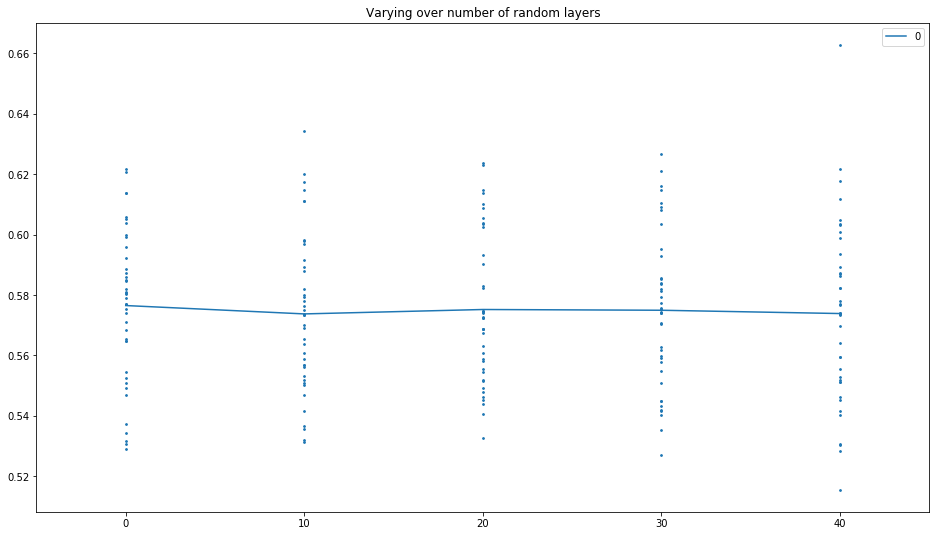

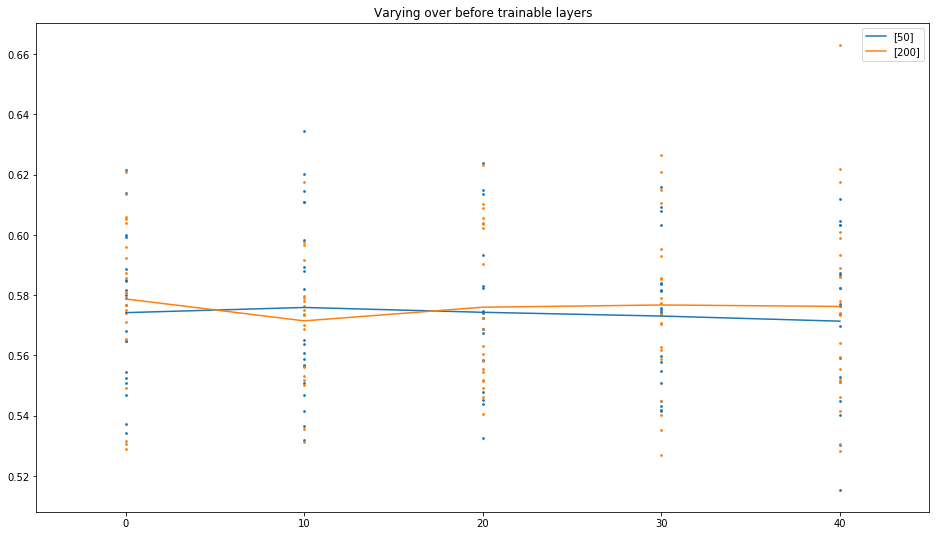

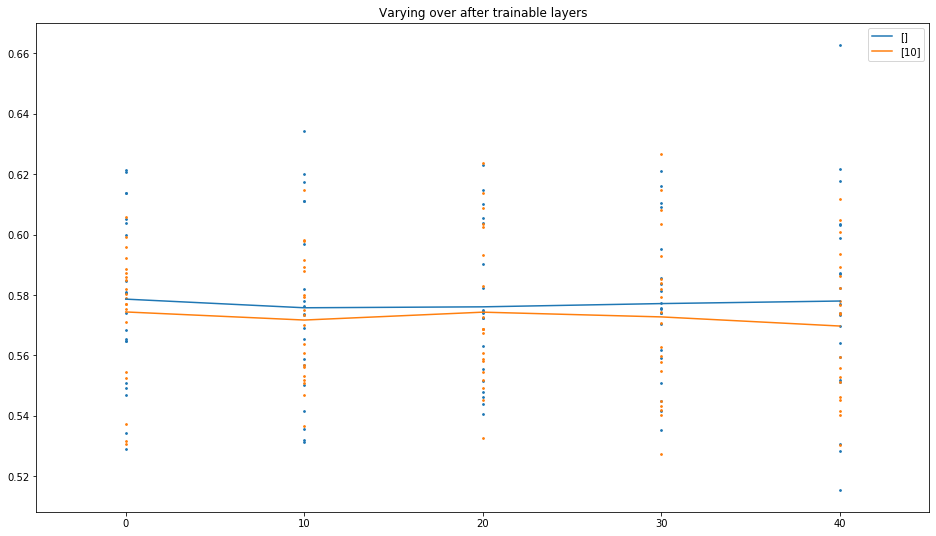

In [41]:
plot_marginals(
    results_double_residual,
    [
        "Before trainable layers",
        "Number of random layers",
        "After trainable layers",
    ],
    values,
    1,
)

In [42]:
with open("output/result3.output", 'w+') as file:
    file.writelines([str(results_double_residual.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results_double_residual.reshape(-1, folds))

### Same as before, but with relu instead of tanh

In [34]:
results_double_residual_relu = np.zeros(model_configurations_residual.shape[:-1] + (folds,))

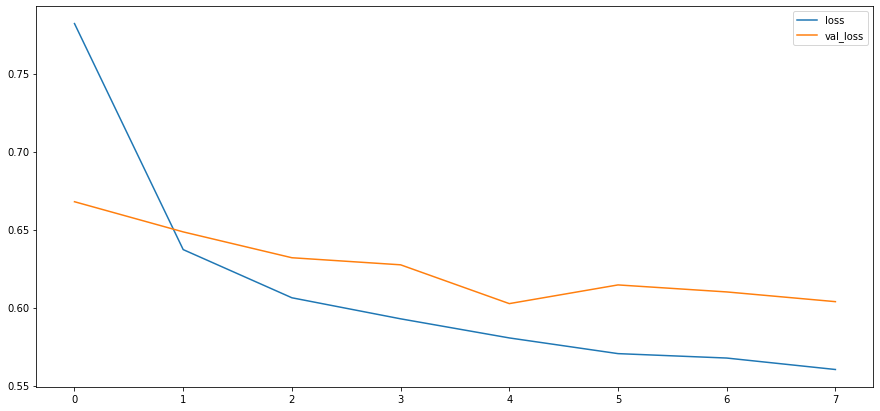

29305/29305 [==============================] - 11s 361us/sample - loss: 0.5603 - val_loss: 0.6038


In [35]:
for i, model_type in list(enumerate(model_configurations_residual.reshape(-1, 3))):
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        print(i, j, sep=", ")
        half_validate = round(len(test_ids) / 2)
        
        model = build_double_residual_model(*model_type, random_activation="relu")
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                ),
#                 keras.callbacks.TensorBoard(
#                     log_dir="logs/" + "log_" + datetime.now().strftime("%Y%m%d-%H%M%S"),
#                     histogram_freq=1,
#                     embeddings_freq=1,
#                     profile_batch=0,
#                 ),
                PlotLosses(),
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results_double_residual_relu.reshape(-1, folds)[i, j] = score

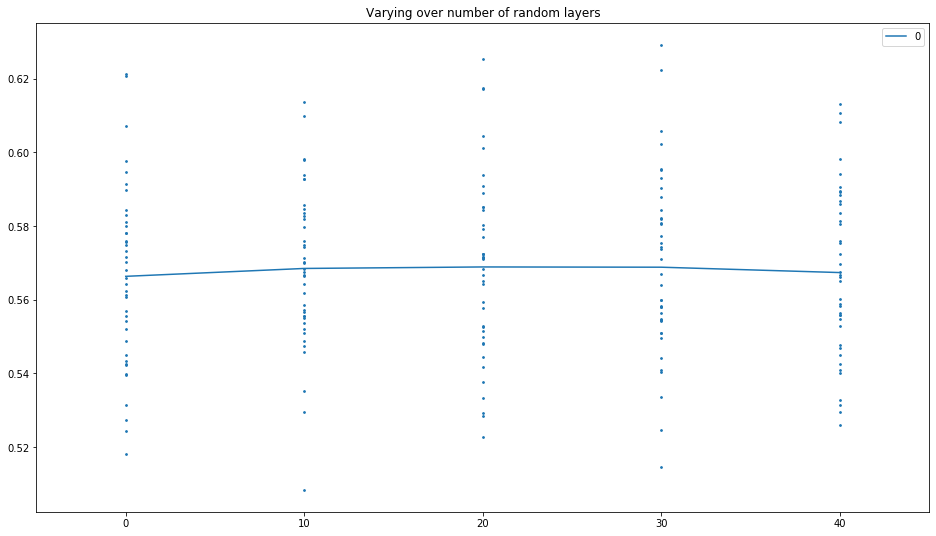

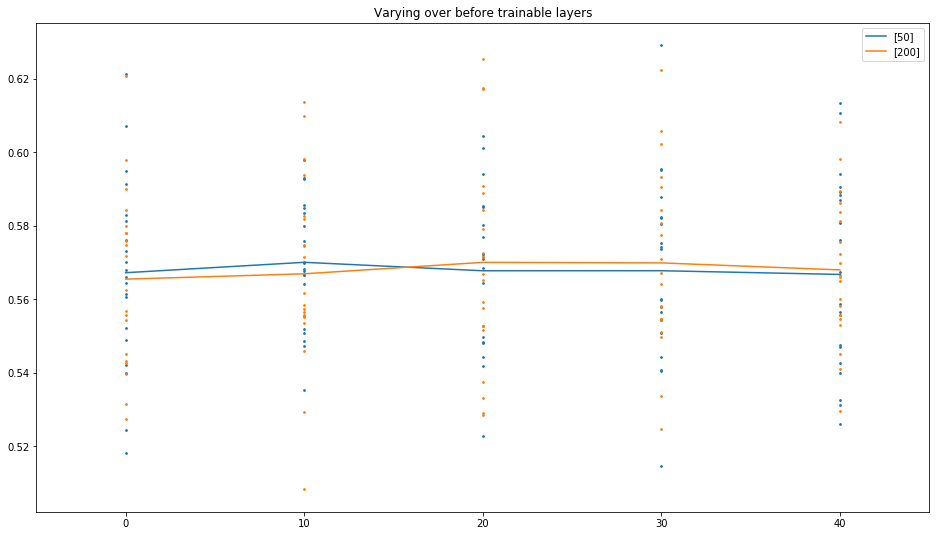

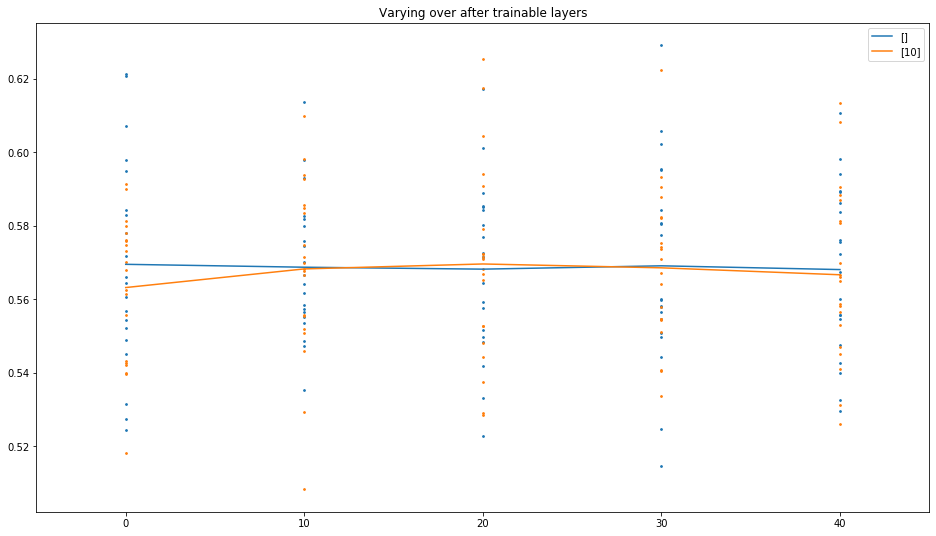

In [37]:
plot_marginals(
    results_double_residual_relu,
    [
        "Before trainable layers",
        "Number of random layers",
        "After trainable layers",
    ],
    values,
    1,
)

In [38]:
with open("output/result4.output", 'w+') as file:
    file.writelines([str(results_double_residual_relu.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results_double_residual_relu.reshape(-1, folds))

### Scalar per node

In [53]:
class ElementWiseLayer(keras.layers.Layer):
    def __init__(self):
        super(ElementWiseLayer, self).__init__()
        
    def build(self, input_shape):
        print(input_shape)
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1],),
            initializer=tf.random_uniform_initializer(),
            trainable=True,
        )
        
    def call(self, x):
        return tf.multiply(x, self.kernel)

In [51]:
def build_model_elementwise_layer(
    before_trainable_layers=[],
    random_layers=0,
    after_trainable_layers=[],
    regularization=1e-6,
    random_activation="relu",
):
    inputs = [keras.layers.Input(shape=(train.shape[1],))]
    state = inputs[0]
    
    for i, layer_size in enumerate(before_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        state = keras.layers.BatchNormalization()(state)
        
    for i in range(random_layers):
        random_layer_output = keras.layers.Dense(
            before_trainable_layers[-1],
            activation=random_activation,
            trainable=False,
        )(state)
        random_layer_output_scaled = ElementWiseLayer()(random_layer_output)
        state = keras.layers.Add()([state, random_layer_output_scaled])
        state = keras.layers.BatchNormalization()(state)
    
    for i, layer_size in enumerate(after_trainable_layers):
        state = keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        )(state)
        
    state = keras.layers.Dense(1)(state)
    return keras.Model(inputs, outputs=state)

In [37]:
results_elementwise_layer = np.zeros(model_configurations_residual.shape[:-1] + (folds,))

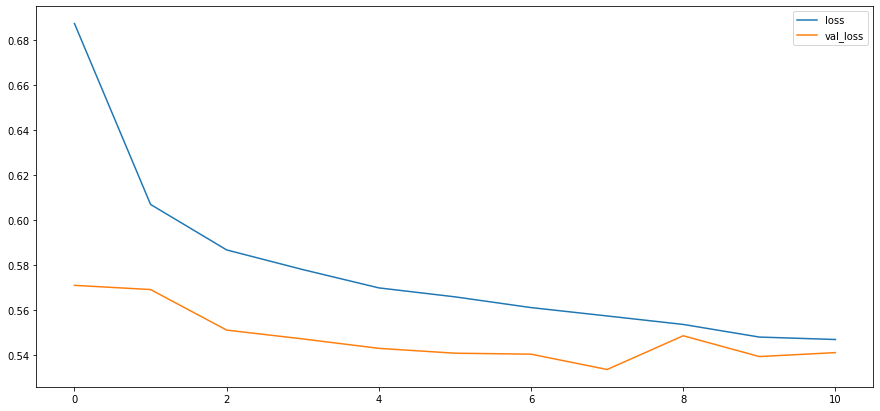

29305/29305 [==============================] - 11s 390us/sample - loss: 0.5470 - val_loss: 0.5412


In [54]:
for i, model_type in list(enumerate(model_configurations_residual.reshape(-1, 3)))[2:]:
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=10, shuffle=True).split(np.arange(dataset.shape[0]))):
        print(i, j, sep=", ")
        half_validate = round(len(test_ids) / 2)
        
        model = build_model_elementwise_layer(*model_type)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=3,
                    restore_best_weights=True,
                ),
#                 keras.callbacks.TensorBoard(
#                     log_dir="logs/" + "log_" + datetime.now().strftime("%Y%m%d-%H%M%S"),
#                     histogram_freq=1,
#                     embeddings_freq=1,
#                     profile_batch=0,
#                 ),
                PlotLosses(),
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results_elementwise_layer.reshape(-1, folds)[i, j] = score

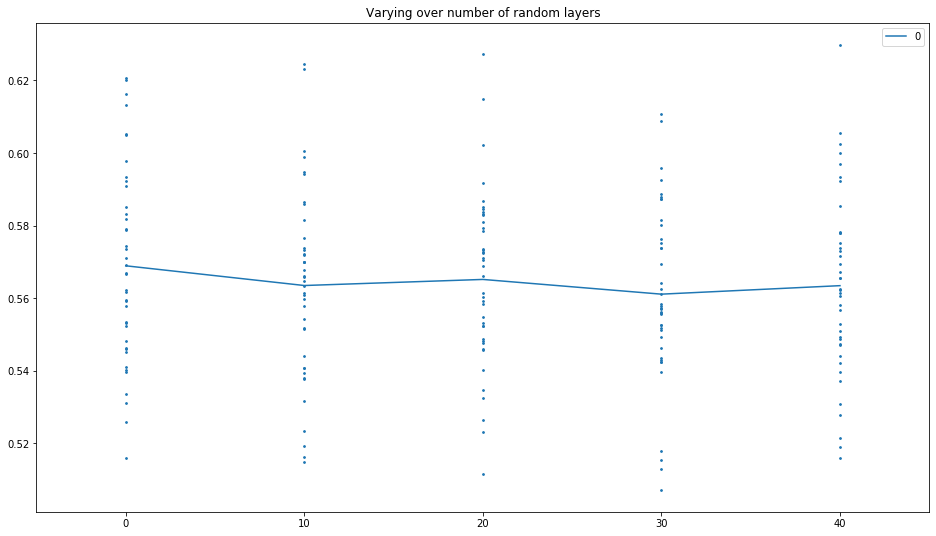

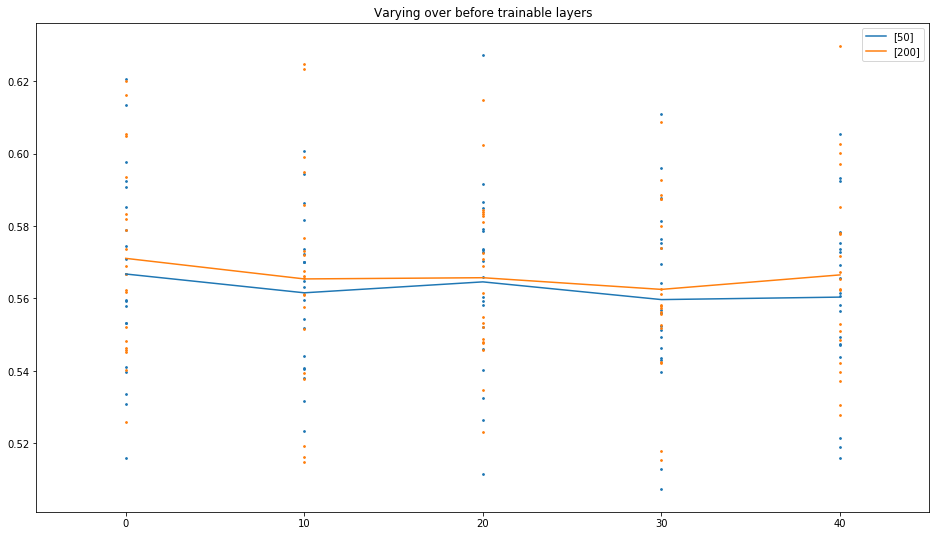

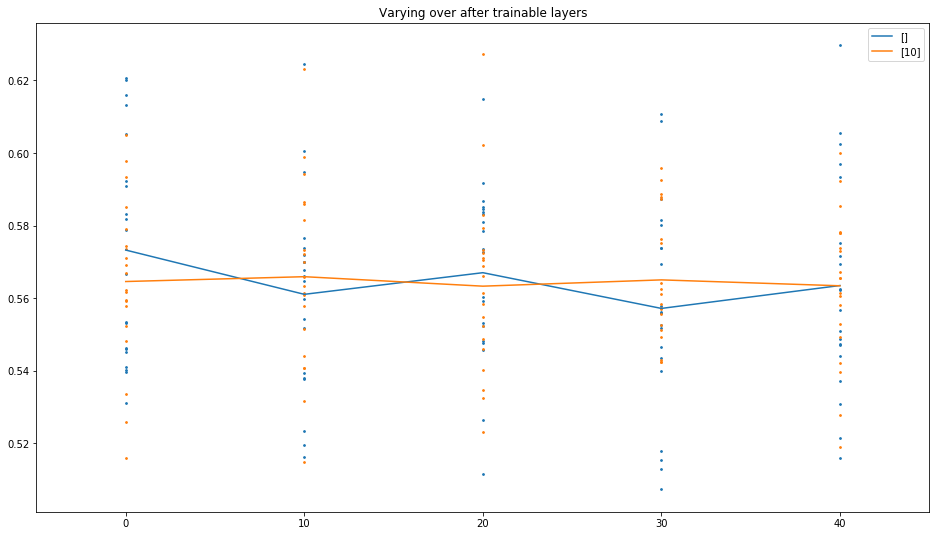

In [55]:
plot_marginals(
    results_elementwise_layer,
    [
        "Before trainable layers",
        "Number of random layers",
        "After trainable layers",
    ],
    values,
    1,
)

In [56]:
with open("output/result5.output", 'w+') as file:
    file.writelines([str(results_elementwise_layer.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results_elementwise_layer.reshape(-1, folds))

# Model search with limited number of trainable parameters

## Limited to 100

In [137]:
activations_to_try = ["linear", "relu", "tanh"]

In [410]:
domain = [
    {
        "name": "random_layer_size",
        "type": "continuous",
        "domain": (log_space(4), log_space(100)),
    },
    {
        "name": "nr_of_random_layers",
        "type": "continuous",
        "domain": (log_space(0, shift=1), log_space(100, shift=1)),
    },
    {
        "name": "end_layer_size",
        "type": "continuous",
        "domain": (log_space(2), log_space(25)),
    },
    {
        "name": "have_end_layer",
        "type": "discrete",
        "domain": (0, 1),
    },
    {
        "name": "random_activation",
        "type": "discrete",
        "domain": tuple(range(len(activations_to_try))),
    },
    {
        "name": "end_activation",
        "type": "discrete",
        "domain": tuple(range(len(activations_to_try))),
    },
    {
        "name": "batch_norm",
        "type": "discrete",
        "domain": (0, 1),
    },
]

In [412]:
def compile(*values, sep=" "):
    return sep.join(map(str, values))

In [413]:
def pars(*values):
    return "(" + compile(*values) + ")"

In [414]:
def f_normal(index):
    return "x[:, {}]".format(index)

In [415]:
def f_ul(index, shift=1e-12):
    return compile("(np.exp(", f_normal(index), ") - ", shift, ")", sep="")

In [416]:
def f_round(v):
    return "np.round(" + str(v) + ")"

In [417]:
nr_trainable_weights = compile(
            f_round(f_ul(1, shift=1)),
            "+",
            f_normal(3), "*", pars(pars(f_round(f_ul(0)), "+", 1), "*", f_round(f_ul(2)), "+", pars(f_round(f_ul(2)), "+", 1)),
            "+",
            pars(1, "-", f_normal(3)), "*", pars(f_round(f_ul(0)), "+", 1),
)
constraints = [
    {
        "name": "max_trainable_weights",
        "constraint": compile(nr_trainable_weights, "-", 100 + 1),
    },
    {
        "name": "min_trainable_weights",
        "constraint": compile("-", pars(nr_trainable_weights), "+", 30),
    },
]

In [313]:
def nr_trainable_params(
    random_layer_size,
    nr_of_random_layers,
    end_layer_size,
    have_end_layer,
    random_activation,
    end_activation,
    batch_norm,
):
    total = 0
    total += nr_of_random_layers

    if have_end_layer:
        total += (random_layer_size + 1) * end_layer_size
        total += end_layer_size * 1 + 1
    else:
        total += random_layer_size * 1 + 1

    return total

In [350]:
def nr_trainable_params2(
    random_layer_size,
    nr_of_random_layers,
    end_layer_size,
    have_end_layer,
    random_activation,
    end_activation,
    batch_norm,
):
    have_end_layer = int(have_end_layer)
    return nr_of_random_layers + have_end_layer * (random_layer_size + 2) * end_layer_size + (1 - have_end_layer) * random_layer_size + 1

In [312]:
def build_small_double_residual_model(
    random_layer_size,
    nr_of_random_layers,
    end_layer_size,
    have_end_layer,
    random_activation,
    end_activation,
    batch_norm,
):
    inputs = [keras.layers.Input(shape=(train.shape[1],))]
    state = inputs[0]
    
    state = keras.layers.Dense(
        random_layer_size,
        activation=random_activation,
        trainable=False,
    )(state)
    if batch_norm:  
        state = keras.layers.BatchNormalization(trainable=False)(state)
        
    for _ in range(nr_of_random_layers):
        random_layer_output = keras.layers.Dense(
            random_layer_size,
            activation=random_activation,
            trainable=False,
        )(state)
        scaled = Scalar()(random_layer_output)
        state = keras.layers.Add()([state, scaled])
        if batch_norm:
            state = keras.layers.BatchNormalization(trainable=False)(state)
    
    if have_end_layer:
        state = keras.layers.Dense(
            end_layer_size,
            activation=end_activation,
        )(state)
        
    state = keras.layers.Dense(1)(state)
    return keras.Model(inputs, outputs=state)

In [423]:
def test_f(hyperparams):
    config = dict(zip(map(lambda var: var["name"], domain), hyperparams[0]))
    
    for var, shift in [
        ("random_layer_size", None),
        ("nr_of_random_layers", 1),
        ("end_layer_size", None),
    ]: config[var] =  un_log_space(config[var]) if shift is None else un_log_space(config[var], shift=shift)
    for var in [
        "random_layer_size",
        "nr_of_random_layers",
        "end_layer_size",
    ]: config[var] = round(config[var])
    for var in config.keys():
        config[var] = int(config[var])
    for var in [
        "random_activation",
        "end_activation",
    ]:
        config[var] = activations_to_try[config[var]]
    for var in [
        "have_end_layer",
        "batch_norm",
    ]: config[var] = bool(config[var])
        
    scores = list()
    for train_ids, test_ids in KFold(n_splits=8, shuffle=True).split(np.arange(dataset.shape[0])):
        half_validate = round(len(test_ids) / 2)
        
        model = build_small_double_residual_model(**config)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=50,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=3,
                    min_delta=1e-3,
                    restore_best_weights=True,
                ),
            ],
            verbose=0,
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        scores.append(score)
    return np.mean(scores)

In [424]:
bo = BayesianOptimization(
    f=test_f,
    X=bo2.X, Y=bo2.Y,
    domain=domain,
    constraints=constraints,
    jitter=.05,
)

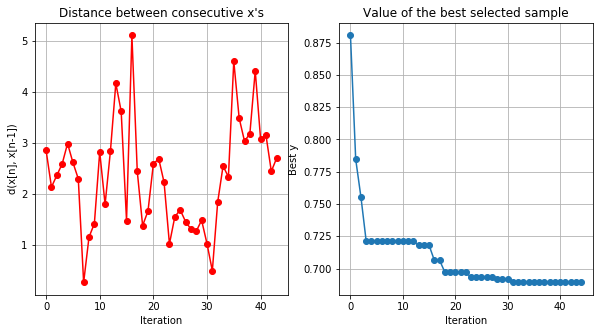

In [460]:
bo.run_optimization()
bo.plot_convergence()

In [465]:
np.savetxt("bo.X", bo.X)
np.savetxt("bo.Y", bo.Y)

In [437]:
domain

[{'name': 'random_layer_size',
  'type': 'continuous',
  'domain': (1.3862943611201406, 4.605170185988102)},
 {'name': 'nr_of_random_layers',
  'type': 'continuous',
  'domain': (0.0, 4.61512051684126)},
 {'name': 'end_layer_size',
  'type': 'continuous',
  'domain': (0.6931471805604453, 3.2188758248682405)},
 {'name': 'have_end_layer', 'type': 'discrete', 'domain': (0, 1)},
 {'name': 'random_activation', 'type': 'discrete', 'domain': (0, 1, 2)},
 {'name': 'end_activation', 'type': 'discrete', 'domain': (0, 1, 2)},
 {'name': 'batch_norm', 'type': 'discrete', 'domain': (0, 1)}]

In [461]:
best = np.argsort(bo.Y.reshape(-1))[:10]
bo.Y[best]

array([[0.6892771 ],
       [0.69042442],
       [0.69206689],
       [0.69324587],
       [0.69508345],
       [0.69533265],
       [0.69595696],
       [0.69605661],
       [0.69702825],
       [0.6973611 ]])

In [464]:
un_logged = np.stack([
    np.round(un_log_space(bo.X[:, 0])),
    np.round(un_log_space(bo.X[:, 1], shift=1)),
    np.round(un_log_space(bo.X[:, 2])),
    bo.X[:, 3],
    bo.X[:, 4],
    bo.X[:, 5],
    bo.X[:, 6],
], axis=1)
un_logged[best]

array([[95.,  4., 25.,  0.,  1.,  1.,  1.],
       [95.,  4., 12.,  0.,  1.,  1.,  1.],
       [98.,  1., 25.,  0.,  1.,  0.,  1.],
       [85.,  0., 13.,  0.,  1.,  0.,  1.],
       [95.,  4., 15.,  0.,  1.,  1.,  1.],
       [99.,  0., 16.,  0.,  1.,  0.,  1.],
       [92.,  5., 21.,  0.,  1.,  2.,  1.],
       [90.,  1., 21.,  0.,  1.,  1.,  1.],
       [97.,  1., 12.,  0.,  1.,  1.,  1.],
       [97.,  2., 25.,  0.,  1.,  0.,  1.]])